# Timelags: Bundle Model

Compute the timelags for our bundle model.

In [2]:
import os
import sys

import numpy as np
from scipy.interpolate import splev,interp1d
import scipy.stats
import h5py
import dask
import dask.array
import dask.distributed
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map,GenericMap
from sunpy.util.metadata import MetaDict
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import SqrtStretch,ImageNormalize,AsinhStretch,LogStretch

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import plot_aia_channels

sys.path.append('../../scripts/')
from timelags import AIATimeLags, AIATimeLagsObserved
from idl_colormaps import bgry_004_idl_cmap
from idl_procedures import c_correlate

%matplotlib inline

In [6]:
client = dask.distributed.Client(processes=False)
client

Client Scheduler: inproc://128.42.128.76/74678/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 64 Memory: 270.38 GB


In [30]:
client.close()

## Load Data

In [3]:
aia = InstrumentSDOAIA([5000,25000]*u.s)
aia.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/simple/SDO_AIA_counts.h5'

In [4]:
tl = AIATimeLags(aia, 'intensity_maps_bundle.h5',
                 fits_root_path='/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/simple/'
                )

FloatProgress(value=0.0)

In [5]:
xc,yc = -325*u.arcsec, -200*u.arcsec
dx,dy = 1*u.arcsec, 1*u.arcsec
lower_left_corner = (xc-dx/2,yc-dy/2)
upper_right_corner = (xc+dx/2,yc+dy/2)
coords  = (lower_left_corner,upper_right_corner)

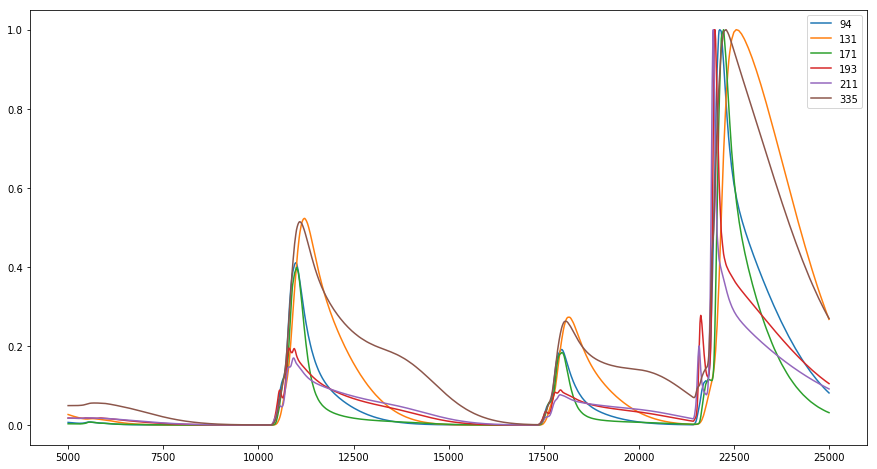

In [8]:
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
for i,channel in enumerate(aia.channels,):
    ts = tl.make_timeseries(channel['name'],lower_left_corner,upper_right_corner)
    ax.plot(aia.observing_time,ts/ts.max(),color=f'C{i}',label=channel['name'])
ax.legend()

In [9]:
channel_pairs = [(94,335), (94,171), (335,211), (335,171), (193,171), (171,131)]

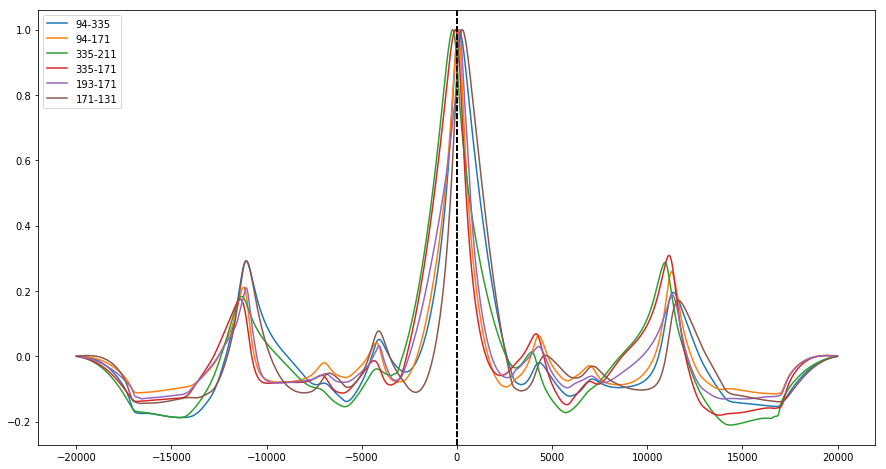

In [13]:
fig = plt.figure(figsize=(15,8),)
ax = fig.gca()
for i,p in enumerate(channel_pairs,):
    # cooling
    cc = tl.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(tl.timelags,cc/cc.max(), color=f'C{i}', ls='-', label='{}-{}'.format(*p))
    ax.axvline(x=0,ls='--',color='k')
#axes[0,0].set_xlim([-5e3,5e3])
ax.legend(loc=2)

## Compute Timelags

In [15]:
timelag_maps = {}
correlation_maps = {}
for p in channel_pairs:
    timelag_maps['{}-{}'.format(*p)] = tl.make_timelag_map(f'{p[0]}',f'{p[1]}', timelag_bounds=(-2*u.hour,2*u.hour))
    correlation_maps['{}-{}'.format(*p)] = tl.make_correlation_map(f'{p[0]}',f'{p[1]}', timelag_bounds=(-2*u.hour,2*u.hour))

## Visualize

In [21]:
correlation_cutoff = 500.0

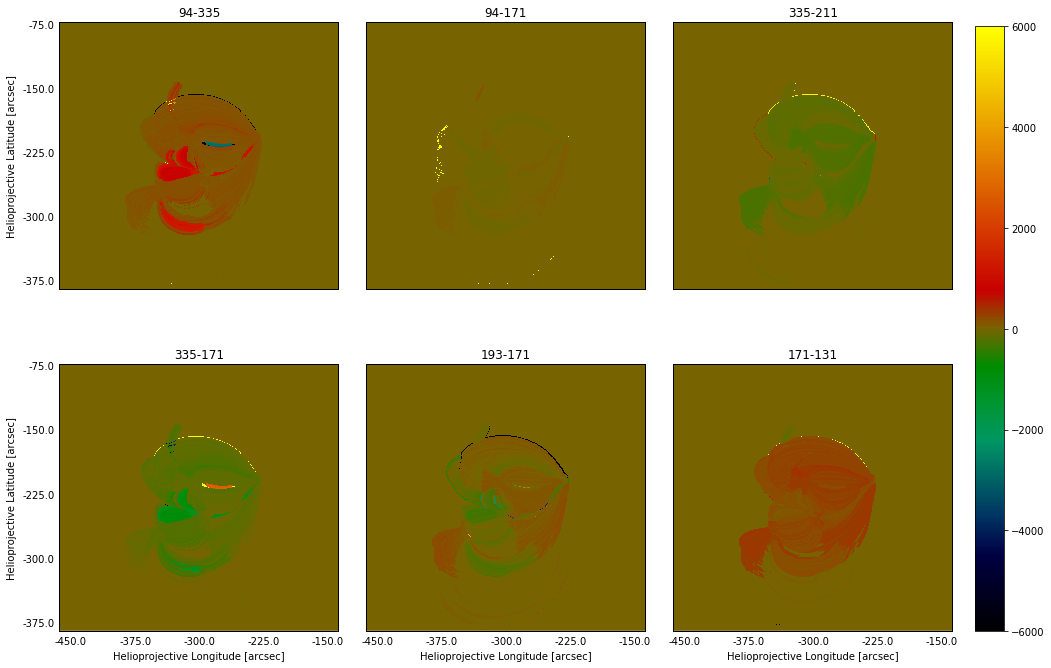

In [24]:
fig = plt.figure(figsize=(16,12))
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
for i,cp in enumerate(channel_pairs):
    m = Map(timelag_maps['{}-{}'.format(*cp)])
    m_cor = Map(correlation_maps['{}-{}'.format(*cp)])
    data = np.where((m_cor.data) < correlation_cutoff, 0., m.data)
    m = Map(data, m.meta)
    ax = fig.add_subplot(2, 3, i+1, projection=m)
    im = m.plot(axes=ax, title=False, annotate=False,
                vmin=-6e3,#-(2*u.hour).to(u.s).value,
                vmax=6e3,#(2*u.hour).to(u.s).value,
                cmap=bgry_004_idl_cmap)
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i % 3 == 0:
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i > 2:
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.set_title('{}-{}'.format(*cp))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
cbar = fig.colorbar(im, cax=cax)

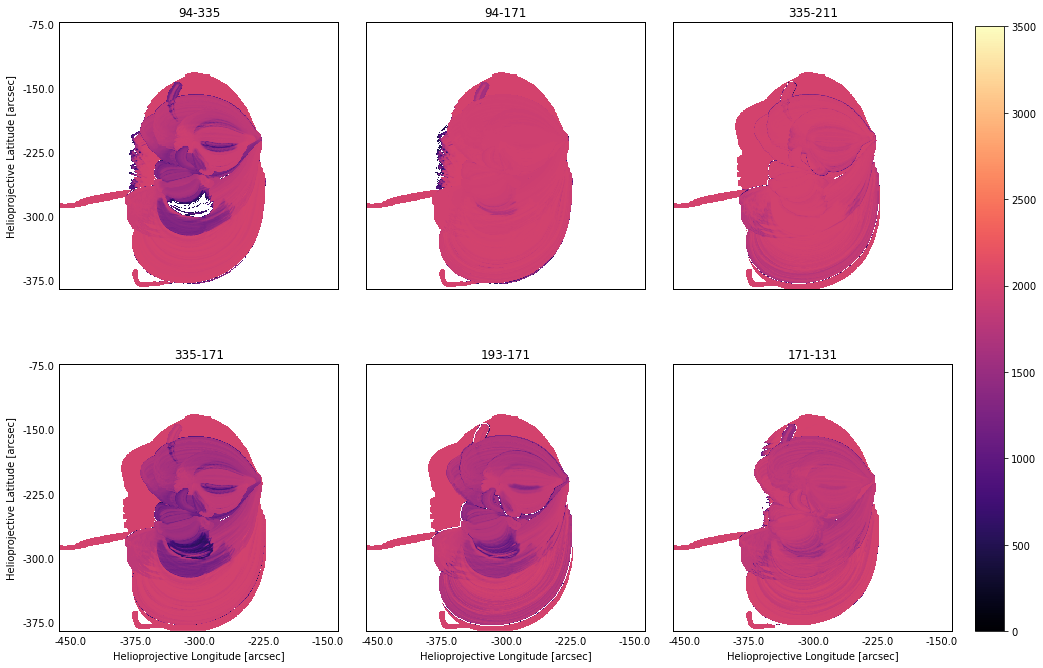

In [25]:
fig = plt.figure(figsize=(16,12))
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
for i,cp in enumerate(channel_pairs):
    m = correlation_maps['{}-{}'.format(*cp)]
    data = np.where(m.data < correlation_cutoff, np.nan, m.data)
    m = Map(data, m.meta)
    ax = fig.add_subplot(2, 3, i+1, projection=m)
    im = m.plot(axes=ax, title=False, annotate=False,
                vmin=0, vmax=3.5e3, cmap='magma')
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i % 3 == 0:
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i > 2:
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.set_title('{}-{}'.format(*cp))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
cbar = fig.colorbar(im, cax=cax)

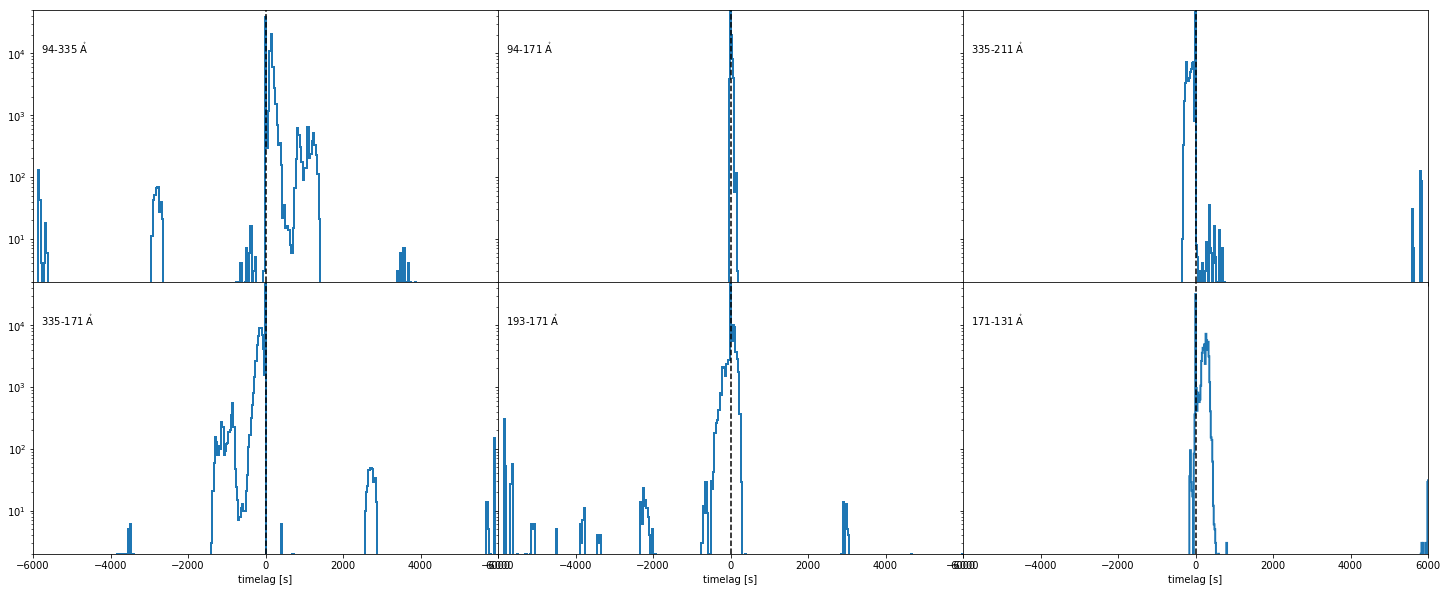

In [29]:
params = {'log':True,'bins':'scott','histtype':'step','lw':2,'normed':False,'cumulative':False}
fig,axes = plt.subplots(2,3,figsize=(25,10),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
# tlm_format = '/storage-home/w/wtb2/data/timelag_synthesis/{}/nei/timelag_maps/timelag_map_{}_{}.fits'
for i,(p,ax)in enumerate(zip(channel_pairs,axes.flatten())):
    tmp = timelag_maps['{}-{}'.format(*p)]
    data = tmp.data.flatten()
    tmp = correlation_maps['{}-{}'.format(*p)]
    data_cor = tmp.data.flatten()
    dist = data[np.where(data_cor >= correlation_cutoff)]
    sk = scipy.stats.skew(dist)
    ax.hist(dist, **params,color=f'C0',ls='-',)
    ax.axvline(x=0,ls='--',color='k')
    ax.text(-5.8e3, 1e4, r'{}-{} $\mathrm{{\mathring{{A}}}}$'.format(*p))
    if i > 2:
        ax.set_xlabel(r'timelag [s]')
axes[0,0].set_xlim(-6e3,6e3);
axes[0,0].set_ylim(2,5e4);